In [1]:
%load_ext autoreload
%autoreload 2

In [76]:
import pandas as pd
from llama_cpp import Llama
from langdetect import detect
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Prepare dataset 

Prepare the dataset for use, explaining your selection criteria for the subset you choose

In [9]:
splits = {'train': 'train.jsonl', 'test': 'test.jsonl'}
df = pd.read_json("hf://datasets/ajaykarthick/imdb-movie-reviews/" + splits["train"], lines=True)

In [13]:
df.head()

,review,label
0,"Ms Aparna Sen, the maker of Mr & Mrs Iyer, dir...",0
1,"I have seen this film only once, on TV, and it...",0
2,I was only fourteen when I first saw the Alien...,1
3,This marvelous short will hit home with everyo...,0
4,If you are 10 years old and never seen a movie...,1


In [ ]:
# Should check that all these reviews are in English so will use the `langdetect` library to do that
# N.B. this is quite slow(about 2 mins on my machine)
df["language"] = df["review"].apply(detect)

In [ ]:
# Let's also add a column for the length of the review
df["review_length"] = df["review"].apply(lambda x: len(x))

In [ ]:
df.head()

,review,label,language,review_length
0,"Ms Aparna Sen, the maker of Mr & Mrs Iyer, dir...",0,en,2408
1,"I have seen this film only once, on TV, and it...",0,en,662
2,I was only fourteen when I first saw the Alien...,1,en,1481
3,This marvelous short will hit home with everyo...,0,en,830
4,If you are 10 years old and never seen a movie...,1,en,238


In [25]:
df.describe()

,label,review_length
count,40000.000000,40000.000000
mean,0.500000,1312.303950
std,0.500006,993.920001
min,0.000000,41.000000
25%,0.000000,699.000000
50%,0.500000,970.000000
75%,1.000000,1598.000000
max,1.000000,13704.000000


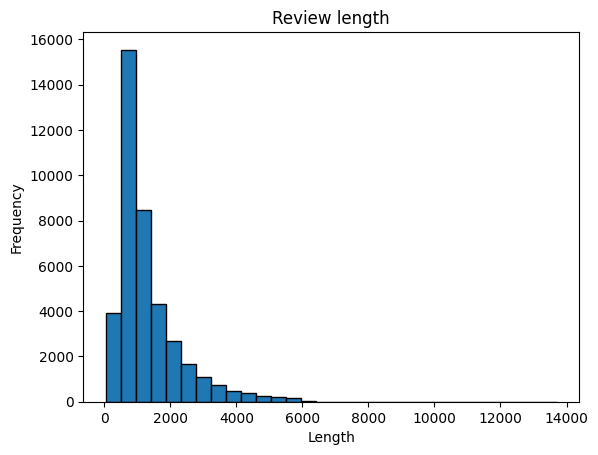

In [21]:
plt.hist(df['review_length'], bins=30, edgecolor='black')

# Add titles and labels
plt.title('Review length')
plt.xlabel('Length')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [33]:
df['review_length_bin'] = pd.qcut(df['review_length'], q=10)


In [34]:
df.head()

,review,label,language,review_length,review_length_bin
0,"Ms Aparna Sen, the maker of Mr & Mrs Iyer, dir...",0,en,2408,"(1829.0, 2583.0]"
1,"I have seen this film only once, on TV, and it...",0,en,662,"(503.0, 662.0]"
2,I was only fourteen when I first saw the Alien...,1,en,1481,"(1412.0, 1829.0]"
3,This marvelous short will hit home with everyo...,0,en,830,"(739.0, 838.0]"
4,If you are 10 years old and never seen a movie...,1,en,238,"(40.999, 503.0]"


In [ ]:
# Let's check out the language of the reviews quickly
df['language'].unique()

array(['en', 'id'], dtype=object)

In [24]:
# Have a look at the examples where the language is not English
df[df["language"] != "en"]

,review,label,language,review_length
24998,.....whoops - looks like it's gonna cost you a...,0,id,730


Looks like all the reviews are in English so most immediate way of subsetting the data is by review_length and the label. Could go deep with something like https://pypi.org/project/py-readability-metrics/ but don't really want to overdo this. 

As for size of subset let's go with 5k for now (not sure what constraints of my machine are yet) and will review later.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    df,
    df[["review_length", "label"]],
    stratify=df[["review_length_bin", "label"]],
    test_size=5000,
)

In [39]:
X_train.describe()

,label,review_length
count,35000.000000,35000.000000
mean,0.500000,1312.883314
std,0.500007,995.889168
min,0.000000,41.000000
25%,0.000000,699.000000
50%,0.500000,970.000000
75%,1.000000,1597.000000
max,1.000000,13704.000000


OK looks like that's worked, let's clean up and get onto the next bit

In [38]:
X_test.describe()

,label,review_length
count,5000.00000,5000.000000
mean,0.50000,1308.248400
std,0.50005,980.113877
min,0.00000,64.000000
25%,0.00000,698.000000
50%,0.50000,970.000000
75%,1.00000,1606.250000
max,1.00000,7068.000000


In [42]:
data = X_test[['review', 'label']]

## Implement local inference

- Choose optimal inference parameters (e.g., temperature, top_p, top_k) for each model
- https://llama-cpp-python.readthedocs.io/en/latest/api-reference/#llama_cpp.Llama.create_chat_completion contains avaliable parameters 
- It doesn't look like I can batch up responses so will have to just keep hitting the model: https://github.com/abetlen/llama-cpp-python/issues/1529 
- Unsure how clever I want to be here, will have to see how long it takes to get these responses out 

Stuff to work out / ideas

- [ ] How to choose optimal inference params (do I need to do a bit of a hyperparameter tuning?)
- [x] How do I run this stuff in batch mode: YOU CAN'T
- [ ] Do I want to try and mess around with context window? Feels like default is set like that for a reason. 
- [ ] With context window at 512, randomise which part of review to take (if it's longer than 512) and aggregate 
- [ ] I need to understand top_k / top_p etc. 
- [ ] Need to make a decision RE temperature 
- [ ] Make decision on metrics (what is usually used for sentiment analysis?) Probably don't want to overthink this?
- [ ] 

In [ ]:
# NB this takes c.2mins 

# Small model
llm_small = Llama.from_pretrained(
	repo_id="bartowski/Qwen2.5-0.5B-Instruct-GGUF",
	filename="Qwen2.5-0.5B-Instruct-IQ2_M.gguf",
)
# Big model
llm_big = Llama.from_pretrained(
	repo_id="bartowski/Qwen2.5-1.5B-Instruct-GGUF",
	filename="Qwen2.5-1.5B-Instruct-IQ2_M.gguf",
)

/Users/anna/.pyenv/versions/3.12.7/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
llama_load_model_from_file: using device Metal (AMD Radeon Pro 5500M) - 8176 MiB free
llama_model_loader: loaded meta data with 37 key-value pairs and 290 tensors from /Users/anna/.cache/huggingface/hub/models--bartowski--Qwen2.5-0.5B-Instruct-GGUF/snapshots/41ba88dbac95fed2528c92514c131d73eb5a174b/./Qwen2.5-0.5B-Instruct-IQ2_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = qwen2
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name st

In [69]:
# Output is noisy so we suppress it
llm_small.verbose = False
llm_big.verbose = False

In [ ]:
system_prompt = "You are doing sentiment analysis on movie reviews. Classify the review as positive (0) or negative (1)."

In [ ]:
# Default context window size is 512 characters so we'll stick with that for now
def truncate_review(review, max_length=512):
    return review[:max_length]

def sentiment_inference(llm_model, review, system_prompt):
    response = llm_model.create_chat_completion(
        temperature=1,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": truncate_review(review)},
        ],
    )
    try:
        return int(response["choices"][0]["message"]["content"])
    except ValueError:  # not an int
        return -1  # sentinel value to use for "model failed to return a valid label"

In [72]:
sentiment_inference(llm_small, data["review"].iloc[0], system_prompt)

0

In [58]:
data_tiny = data.head(10)

In [73]:
data_tiny['sentiment_llm_small'] = data_tiny['review'].apply(lambda review: sentiment_inference(llm_small, review, system_prompt))
data_tiny['sentiment_llm_big'] = data_tiny['review'].apply(lambda review: sentiment_inference(llm_big, review, system_prompt))


/var/folders/l8/nxqb7fdj4h79rs4h1s8k5zyr0000gn/T/ipykernel_18334/872085586.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tiny['sentiment_llm_small'] = data_tiny['review'].apply(lambda review: sentiment_inference(llm_small, review, system_prompt))
/var/folders/l8/nxqb7fdj4h79rs4h1s8k5zyr0000gn/T/ipykernel_18334/872085586.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tiny['sentiment_llm_big'] = data_tiny['review'].apply(lambda review: sentiment_inference(llm_big, review, system_prompt))


In [78]:
data_tiny = data_tiny.fillna(-1)

In [81]:
data_tiny

,review,label,sentiment_llm_small,sentiment_llm_big
25534,This is quite possibly the worst film I have e...,1,0.0,0.0
33900,It is beyond me why two million Danish people ...,1,0.0,0.0
7922,I saw this on Zone horror and fully expected i...,0,-1.0,1.0
27153,The Happiest Days of Your Life showcases some ...,0,-1.0,0.0
2101,"Clifton Webb is one of my favorites. However, ...",1,-1.0,0.0
24916,"This is one of my all time favorite movies, it...",0,-1.0,1.0
33580,WHITE FIRE was recommended to me by a guy who ...,0,0.0,0.0
4463,"While possibly the stupidest, most tasteless, ...",0,-1.0,0.0
2834,This movie sucked. The problem was not with th...,1,1.0,-1.0
35401,The second 'Mr. Eko' episode has somewhat less...,0,-1.0,0.0


In [ ]:
accuracy = accuracy_score(data_tiny["label"], data_tiny["sentiment_llm_small"])
print(f"Accuracy: {accuracy}")


precision = precision_score(
    data_tiny["label"], data_tiny["sentiment_llm_small"], average="weighted"
)
print(f"Precision: {precision}")

recall = recall_score(
    data_tiny["label"], data_tiny["sentiment_llm_small"], average="weighted"
)
print(f"Recall: {recall}")


f1 = f1_score(data_tiny["label"], data_tiny["sentiment_llm_small"], average="weighted")
print(f"F1 Score: {f1}")

Accuracy: 0.2
Precision: 0.6
Recall: 0.2
F1 Score: 0.29333333333333333


/Users/anna/.pyenv/versions/3.12.7/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [84]:
accuracy = accuracy_score(data_tiny["label"], data_tiny["sentiment_llm_big"])
print(f"Accuracy: {accuracy}")


precision = precision_score(
    data_tiny["label"], data_tiny["sentiment_llm_big"], average="weighted"
)
print(f"Precision: {precision}")

recall = recall_score(
    data_tiny["label"], data_tiny["sentiment_llm_big"], average="weighted"
)
print(f"Recall: {recall}")


f1 = f1_score(data_tiny["label"], data_tiny["sentiment_llm_big"], average="weighted")
print(f"F1 Score: {f1}")

Accuracy: 0.4
Precision: 0.34285714285714286
Recall: 0.4
F1 Score: 0.36923076923076925


/Users/anna/.pyenv/versions/3.12.7/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [82]:
tqdm.pandas()